# EPTNR Data Preparation

![Data Pipeline](../figures/data_pipeline.svg)

In [1]:
import os
from pathlib import Path
import json

import osmnx as ox
import geopandas as gpd
import pandas as pd

from eptnr.graph_generation.problem_graph_generator import ProblemGraphGenerator
from eptnr.graph_generation.utils.osm_utils import get_pois_gdf

## Prepare graph

In [2]:
BASE_PATH = Path('.')
city = "Atlanta"
state = "GA"
country = "USA"
osm_poi_tags = {'amenity':'school'}
poi_file = "atlanta_pois.geojson"
gtfs_file = "atlanta_transit_feed_12_05.zip"
census_file = "atlanta_census.parquet"
neighborhood_file = "atlanta_neighborhoods.geojson"
crs = "EPSG:4326"

### Create POI file

In [3]:
poi_gdf = get_pois_gdf(', '.join([city, state, country]), osm_poi_tags)
poi_gdf.head()

,name,geometry
osmid,,
358679583,Archbishop R Ryan Memorial School,POINT (-84.37163 33.75503)
358682163,Capitol View Elementary School,POINT (-84.40687 33.71566)
358682296,KIPP West Atlanta Young Scholars Academy,POINT (-84.41743 33.75705)
358682299,Carter School,POINT (-84.35604 33.84705)
358682323,Carver Vocational School,POINT (-84.38899 33.71851)


In [4]:
poi_gdf.to_file(BASE_PATH / poi_file, driver='GeoJSON', crs=crs)

### Create census file

In [5]:
atlanta_census = gpd.read_file(BASE_PATH / "atlanta_census_2020_2010" / "atlanta_census_2020_2010.geojson")
# Reproject the geometries to the target CRS
atlanta_census = atlanta_census.to_crs(crs)

with open(BASE_PATH / "atlanta_census_2020_2010" / "metadata.json", 'r') as f:
    atlanta_neigborhoods_md = json.load(f)
    
# Keep neessary columns and rename
atlanta_census = atlanta_census[['name', 'p0010001_2020', 'p0010003_2020', 'geometry']]
column_mapping = {'name':'neighborhood', 'p0010001_2020': 'n_inh', 'p0010003_2020': 'n_w'}
atlanta_census = atlanta_census.rename(columns=column_mapping)
atlanta_census['n_nw'] = atlanta_census['n_inh'] - atlanta_census['n_w']

In [6]:
# atlanta_neigborhoods_md['columns']
# >>> {
# >>>     'title': 'Race',
# >>>     'releases': ['dec2010_pl94', 'dec2020_pl94'],
# >>>     'columns': {
# >>>         'name': 'Geography Name',
# >>>         'P0010001_2020': 'P1-1: Total (2020)',
# >>>         'P0010002_2020': 'P1-2: Population of one race (2020)',
# >>>         'P0010003_2020': 'P1-3: White alone (2020)',
# >>>         ...
# >>>     }
# >>> }

In [7]:
atlanta_census['res_centroid'] = atlanta_census.geometry.centroid
# Prepend 'RC_' to the neighborhood name
atlanta_census['neighborhood'] = atlanta_census['neighborhood'].apply(lambda x: 'RC_' + x)
atlanta_census

/tmp/ipykernel_47584/2134778480.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  atlanta_census['res_centroid'] = atlanta_census.geometry.centroid


,neighborhood,n_inh,n_w,geometry,n_nw,res_centroid
0,RC_Peachtree Heights East,1153,1049,"MULTIPOLYGON (((-84.38746 33.82865, -84.38746 ...",104,POINT (-84.38295 33.82574)
1,RC_Mt. Gilead Woods,82,7,"MULTIPOLYGON (((-84.50624 33.70161, -84.50640 ...",75,POINT (-84.50368 33.69995)
2,RC_Oakcliff,296,10,"MULTIPOLYGON (((-84.50069 33.75894, -84.49581 ...",286,POINT (-84.49806 33.76169)
3,RC_Just Us,30,0,"MULTIPOLYGON (((-84.42357 33.75456, -84.42455 ...",30,POINT (-84.42486 33.75258)
4,RC_Bush Mountain,372,35,"MULTIPOLYGON (((-84.43754 33.72663, -84.42730 ...",337,POINT (-84.43204 33.72751)
...,...,...,...,...,...,...
232,RC_Edmund Park,246,213,"MULTIPOLYGON (((-84.34185 33.79611, -84.34394 ...",33,POINT (-84.34195 33.79468)
233,RC_Morningside/Lenox Park,10312,7994,"MULTIPOLYGON (((-84.34859 33.80455, -84.34862 ...",2318,POINT (-84.35640 33.79933)
234,RC_East Atlanta,5885,3141,"MULTIPOLYGON (((-84.34434 33.74559, -84.34695 ...",2744,POINT (-84.33705 33.73497)
235,RC_Huntington,69,0,"MULTIPOLYGON (((-84.52580 33.66409, -84.52580 ...",69,POINT (-84.52728 33.66130)


In [8]:
def check_has_any_na(gdf: gpd.GeoDataFrame) -> bool:
    return gdf.apply(lambda x: x.isna(), axis=1).any(axis=0).any()

if not check_has_any_na(atlanta_census):
    atlanta_census.to_parquet(BASE_PATH / census_file)
else:
    raise ValueError("The census data contains NaN values.")

### Create neighborhoods file

In [9]:
atlanta_neighborhoods = gpd.GeoDataFrame(atlanta_census[['neighborhood','res_centroid']], geometry='res_centroid', crs=crs)
atlanta_neighborhoods['name'] = atlanta_neighborhoods['neighborhood']
del atlanta_neighborhoods['neighborhood']
atlanta_neighborhoods.to_file(BASE_PATH / neighborhood_file, driver='GeoJSON', crs=crs)

### Generate EPTNR problem graph

In [10]:
gtfs_zip_file_path = BASE_PATH / gtfs_file
out_dir_path = BASE_PATH / 'resulting_graph/'

if not os.path.exists(out_dir_path):
    os.mkdir(out_dir_path)

day = "monday"
time_from = "07:00:00"
time_to = "09:00:00"

In [11]:

graph_generator = ProblemGraphGenerator(city=city, gtfs_zip_file_path=gtfs_zip_file_path,
                                        out_dir_path=out_dir_path, day=day,
                                        time_from=time_from, time_to=time_to,
                                        poi_gdf=poi_gdf, res_centroids_gdf=atlanta_neighborhoods,
                                        geographical_neighborhoods_gdf=atlanta_census,
                                        clip_graph_to_neighborhoods=True,
                                        distances_computation_mode='haversine')

resulting_graph_file = graph_generator.generate_problem_graph()

DEBUG:eptnr.graph_generation.problem_graph_generator:Starting GTFS graph generation on 2023-05-20 02:44:25.415531
DEBUG:eptnr.graph_generation.problem_graph_generator:Created GTFS graph and stored in resulting_graph/Atlanta_pt_network_monday_20230529_20230704.gml
DEBUG:eptnr.graph_generation.problem_graph_generator:Loading GTFS graph
DEBUG:eptnr.graph_generation.problem_graph_generator:Starting OSM graph generation
DEBUG:eptnr.graph_generation.problem_graph_generator:Created OSM Graph and stored in resulting_graph/Atlanta_osm_graph_2023-05-20.gpickle
DEBUG:eptnr.graph_generation.problem_graph_generator:Loading OSM graph
<class 'networkx.utils.decorators.argmap'> compilation 5:5: DeprecationWarning: read_gpickle is deprecated and will be removed in 3.0.Use ``pickle.load(path)``
DEBUG:eptnr.graph_generation.problem_graph_generator:###
Starting problem graph generation
DEBUG:eptnr.graph_generation.problem_graph_generator:Adding residential centroid vertices to graph
DEBUG:eptnr.graph_gene

## Check graph

In [12]:
import matplotlib
from matplotlib import pyplot as plt
import igraph as ig

In [13]:
g : ig.Graph = ig.read(resulting_graph_file)


In [14]:
len(g.es)

1064370

In [15]:
g_transit = g.subgraph_edges(g.es.select(type_ne='walk'), delete_vertices=False)
del g

In [16]:
set(g_transit.es['type'])

{'BUS', 'METRO', 'TRAM'}

In [17]:
# # Filter for a certain modality
# modality = 'METRO'
# g_transit = g_transit.subgraph_edges(g_transit.es.select(type_eq=modality), delete_vertices=False)
#
# # Find the indices of vertices with non-zero degree
# indices = [v.index for v in g_transit.vs if g_transit.degree(v.index) > 0]
#
# # Extract the subgraph with the selected vertices
# g_transit = g_transit.subgraph(indices)

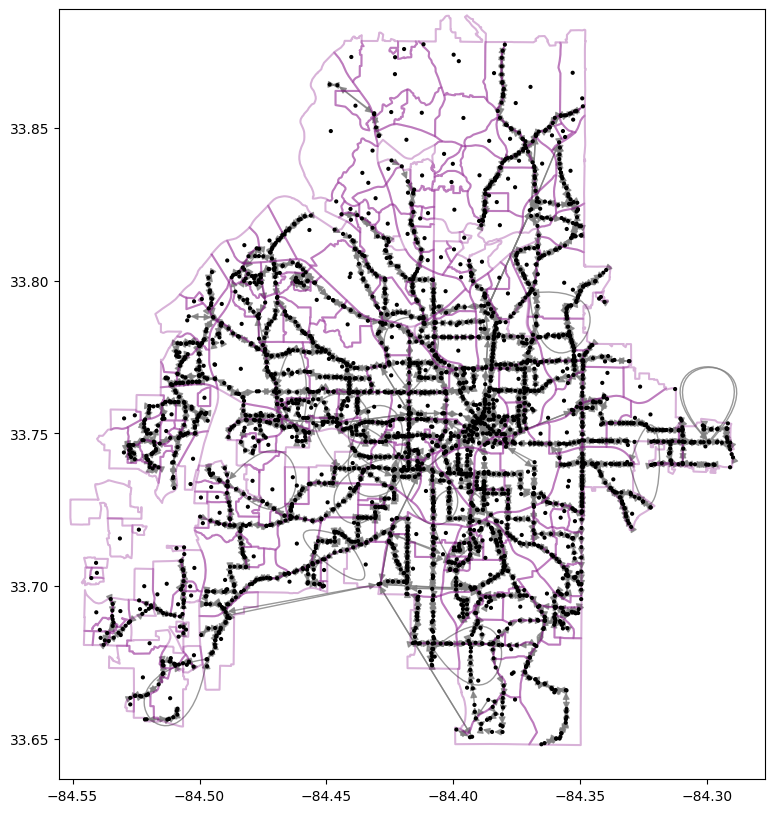

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

base = atlanta_census.boundary.plot(figsize=(15, 15), edgecolor="purple", alpha=0.3, ax=ax)
_ = ig.plot(g_transit, target=base, edge_curved=[0]*len(g_transit.es), vertex_color=[(0,0,0,0.1)], vertex_size=2)

arrows = [e for e in base.get_children() if
          isinstance(e, matplotlib.patches.FancyArrowPatch)]  # This is a PathCollection

label_set = False
for j, (arrow, edge) in enumerate(zip(arrows, g_transit.es)):
    arrow.set_color('gray')
    arrow.set_alpha(0.8)

In [19]:
print(f"Number of METRO edges {len(g_transit.es)}")

Number of METRO edges 3591
